# 3.6 softmax回归的从零开始实现
- **目录**
  -  3.6.1 初始化模型参数
  -  3.6.2 定义softmax操作
  -  3.6.3 定义模型
  -  3.6.4 定义损失函数
  -  3.6.5 分类精度
  -  3.6.6 训练
  -  3.6.7 预测

- 本例使用Fashion-MNIST数据集，并设置数据迭代器的批量大小为256。

In [11]:
%matplotlib inline
import torch
from IPython import display
from d2l import torch as d2l

----------------
- **说明：IPython.display模块简介**
  - `IPython.display` 模块提供了一组用于在 IPython 环境（例如 Jupyter Notebook）中显示各种数据类型的函数。
  - 这些函数可以用来显示：
    * **富文本**: HTML, JavaScript, Markdown
    * **图片**: PNG, JPEG, SVG
    * **视频**
    * **音频**
    * **数学公式**: LaTeX
    * **进度条**
    * **自定义的交互式控件**

In [13]:
# IPython的交互性功能
display.Latex(r'$E=mc^2$')

<IPython.core.display.Latex object>

In [14]:
display.HTML('<h2>Hello World!</h2>')

In [15]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(0,2*np.pi,0.01)
y = np.sin(x)
fig,ax = plt.subplots(1,figsize=(3,3))
ax.plot(x,y)
plt.close(fig)

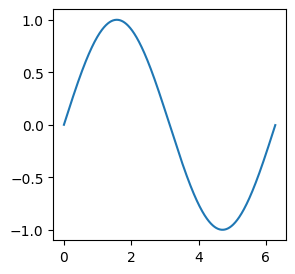

In [16]:
display.display(fig)

-----------

In [17]:
batch_size = 256
## d2l包的load_data_fashion_mnist和前一节一致
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [19]:
## 训练集和测试集的形状
train_iter.dataset.data.shape, test_iter.dataset.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [20]:
## 注意FashionMNIST继承自torch.utils.data.Dataset类
type(train_iter), type(train_iter.dataset), type(train_iter.dataset.data)

(torch.utils.data.dataloader.DataLoader,
 torchvision.datasets.mnist.FashionMNIST,
 torch.Tensor)

## 3.6.1 初始化模型参数

- 每个样本都将用固定长度的向量表示。
- 原始数据集中的每个样本都是$28 \times 28$的图像，本节中**将展平每个图像，把它们看作长度为784的向量。**
- 每个像素位置都可看作成一个特征。
- softmax回归的输出与类别个数一致，**因为数据集有10个类别，所以网络输出维度为10**。
- 权重将构成一个$784 \times 10$的矩阵，
- 偏置将构成一个$1 \times 10$的行向量。
- 与线性回归类似，本例将使用正态分布初始化权重`W`，偏置初始化为0。


In [21]:
num_inputs = 784 ##展平后的图像数据向量长度(或维度)
num_outputs = 10 ##与Fashion-MNIST数据的标签类型数量一致
'''
W的形状是(输入大小，输出大小)，即(784, 10)。
对于每一张图片数据经过全连接层的计算方式：(784,)@(784,10)=(10,)。
如果是n张图片，则是(n,784)@(784,10)=(n,10)，然后再通过softmax求解分类概率。
即矩阵-向量乘法，结果仍是是一个向量。
'''

##注意requires_grad都设为True，表示W,b是需要自动求梯度的张量，用于更新变量
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [22]:
## W和b的形状
W.shape, b.shape

(torch.Size([784, 10]), torch.Size([10]))

## 3.6.2 定义softmax操作

- `sum`运算符如何沿着张量中的特定维度工作, 给定一个矩阵`X`，**默认情况**下`sum`函数对**所有元素求和**。
-  也可以只求同一个轴上的元素，即同一列（轴0）或同一行（轴1）。
- 如果`X`是一个形状为`(2, 3)`的张量，如对列进行求和， 则结果将是一个具有形状`(3,)`的向量。
- 当调用`sum`运算符时，可以指定**保持在原始张量的轴数**，而**不折叠**求和的维度，这将产生一个具有形状`(1, 3)`的二维张量。


In [23]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
## keepdim=True表示即便进行sum,mean等降维操作，仍保持结果和原张量的维度一致
## 此处计算的结果和X张量一样，保持二维张量的计算结果
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

- 实现softmax由三个步骤组成：
  1. 对每个项求幂（使用`exp`）；
  1. 对每一行求和（小批量中每个样本是一行），得到每个样本的规范化常数；
  1. 将每一行除以其规范化常数，确保结果的和为1。
- 回顾一下这个表达式：
$$
\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}.
$$
分母又称为**规范化常数**。



In [24]:
def softmax(X):
    X_exp = torch.exp(X)
    ## 比如本例中，partion是对X_exp行求和，即对每行的10个(列)元素求和
    partition = X_exp.sum(1, keepdim=True)
    ## 返回softmax函数值
    return X_exp / partition  # 这里应用了广播机制

- 对于任何随机输入，**将每个元素变成一个非负数**。
- 此外，依据概率原理，**每行总和为1**。


In [25]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.0823, 0.2326, 0.5270, 0.1230, 0.0349],
         [0.5019, 0.0950, 0.0774, 0.1196, 0.2061]]),
 tensor([1.0000, 1.0000]))

- 注意：矩阵中的非常大或非常小的元素可能造成数值上溢或下溢，但我们没有采取措施来防止这点。

## 3.6.3 定义模型

- 定义softmax操作后，可以**实现softmax回归模型**。
- 下面的代码定义了输入如何通过网络映射到输出。
- 将数据传递到模型之前，需使用`reshape`函数**将每张原始图像展平为向量**。

In [26]:
def net(X):
    '''
    通过reshape函数强制将数据的形状变成与W的形状相互协调，进而进行张量计算。
    如果有60000张图片数据是，那么其形状是(60000,28,28)，经过reshape后变成(60000,784)。
    X@W=(60000,784)@(784,10)=(60000,10)，最后再与偏置求和。
    与偏置求和需使用广播机制，偏置的形状从(10,)广播成(60000, 10)
    '''
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

## 3.6.4 定义损失函数

- 使用交叉熵损失函数，该函数是深度学习中最常见的损失函数
- 交叉熵采用真实标签的预测概率的负对数似然。
- 张量计算：**创建一个数据样本`y_hat`，其中包含2个样本在3个类别的预测概率，以及它们对应的标签`y`。**
- 有了`y`，便知道在第一个样本中，第一类是正确的预测；而在第二个样本中，第三类是正确的预测。
- 然后**使用`y`作为`y_hat`中概率的索引**，选择第一个样本中第一个类的概率和第二个样本中第三个类的概率。


In [27]:
'''
计算交叉熵的一种快速向量算法，而不是使用一般的循环迭代。
下述例子中，将正确与错误分类的概率都取出来，然后用于计算交叉熵。
很显然在y_hat中，第一个样本的分类概率是错误的，第二个样本是正确的。

具体说明：
（1）一共有3个类型，其标签分别为：0, 1, 2。
（2）y的两个值：0表示第一个样本属于标签0类；2表示第二个样本属于标签2类。
（3）y_hat模拟分类结果，很显然其实softmax函数返回值，分别表示2个样本数据在属于3个类型各自的概率。
'''
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y],  -torch.log(y_hat[[0, 1], y])

(tensor([0.1000, 0.5000]), tensor([2.3026, 0.6931]))

In [28]:
# 使用独热编码方式和上述计算方式是一样的
y1 = torch.tensor([[1,0,0],[0,0,1]])
# 第二个计算公式是典型的交叉熵计算公式
y1*y_hat,(y1*y_hat).sum(1)

(tensor([[0.1000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.5000]]),
 tensor([0.1000, 0.5000]))

In [29]:
 -(y1*torch.log(y_hat)).sum(1)

tensor([2.3026, 0.6931])

- **实现交叉熵损失函数**。


In [30]:
def cross_entropy(y_hat, y):
    
    ## 使用到了前一个cell代码的原理：使用标签作为索引取出y_hat中的概率值
    ## 然后计算交叉熵损失
    return - torch.log(y_hat[range(len(y_hat)), y])

## 很显然，根据上一个cell中的数据，第一个样本错误分类的损失很大
# 第二个正确分类的损失很小
cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

## 3.6.5 分类精度

- 给定预测概率分布`y_hat`，当必须输出**硬预测（hard prediction）** 时，通常选择预测概率最高的类。比如输出概率为 [0.3, 0.2, 0.5]，那么硬预测就是类型2（所有类型标签为0,1,2）。

- 当预测与标签分类`y`一致时，即是正确的。分类精度即正确预测数量与总预测数量之比。
- 精度是最重要的性能衡量标准，在训练分类器时几乎总会关注它。

- 为保证计算精度可执行以下操作:
  - 首先，如果`y_hat`是矩阵，那么假定第二个维度存储每个类的预测分数，使用`argmax`获得每行中最大元素的索引来获得预测类别。
  - 然后**将预测类别与真实`y`元素进行比较**。由于等式运算符“`==`”对数据类型很敏感，因此需将`y_hat`的数据类型转换为与`y`的数据类型一致。结果是一个包含0（错）和1（对）的张量。
  - 最后，对“`==`”的结果求和得到正确预测的数量。


In [31]:
1.0 == 1

True

In [32]:
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""    
    ''' 
    (1) len(y_hat.shape) > 1表示有多个维度(此处是二维数组)，即有多个样本数据，每个样本数据又有多个分类概率。
    (2)  y_hat.shape[1] > 1 表示第二维，即列数大于1，表示每个样本的分类概率有多个，一般等于类型个数。
    '''
     
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        ## 调用argmax按行取最大值，即每一行中最大值所在的索引
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    ## 注意此处返回的是分类正确的样本总数
    ## 如若需要计算分类的精度还要除以总样本量
    return float(cmp.type(y.dtype).sum())

In [33]:
float(torch.tensor([1]) == torch.tensor([2]))

0.0

In [34]:
## ==双等号的用法
eq = torch.tensor([1,2,1,3,4]) == torch.tensor([3,2,1,3,5])
eq,eq.sum()

(tensor([False,  True,  True,  True, False]), tensor(3))

- 继续使用之前定义的变量`y_hat`和`y`分别作为预测的概率分布和标签。
  - 第一个样本的预测类别是2（该行的最大元素为0.6，索引为2），这与实际标签0不一致。
  - 第二个样本的预测类别是2（该行的最大元素为0.5，索引为2），这与实际标签2一致。
  - 这两个样本的分类精确率为0.5。


In [35]:
accuracy(y_hat, y) / len(y)

0.5

- 对于任意数据迭代器`data_iter`可访问的数据集，**我们可以评估在任意模型`net`的精度**。


In [37]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    '''
    net.eval()将模型设为评估模式，会影响Batch Normalization和Dropout操作，
    因为在评估模型下二者的某些功能将被停止或减少。后面相应章节内容将涉及到。
    '''
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

- 定义一个实用程序类`Accumulator`（累加器），用于对多个变量进行累加。
- 在上面的`evaluate_accuracy`函数中，`Accumulator`实例中创建了2个变量，分别用于**存储正确预测的数量和预测的总数量**。
- 当遍历数据集时，两者都将随着时间的推移而累加。


In [38]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n
        
    '''
    注意此处*args的用法，其长度和n相同，
    比如后面例子中是3。
    '''
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [39]:
## 即便两个list的长度不一样，也可以进行zip操作
## 自动进行长度匹配
z1 = [1, 2]
z2 = ['a','b','c']
for z in zip(z1, z2):
    print(z)

(1, 'a')
(2, 'b')


- 由于本例使用随机权重初始化`net`模型，因此该模型的精度应接近于随机猜测。
- 例如在有10个类别情况下的精度为0.1。


In [40]:
evaluate_accuracy(net, test_iter)

0.1025

## 3.6.6 训练
- 首先定义一个函数来训练一个迭代周期。
- 请注意，`updater`是更新模型参数的常用函数，它接受批量大小作为参数。
它可以是`d2l.sgd`函数，也可以是框架的内置优化函数。


In [41]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        
        ## 判断模型是使用torch自带优化器，还是自定义优化器
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            ## 每次迭代小批量时，需要将梯度重置为0，因为每个小批量是重新计算的，不累计
            updater.zero_grad() 
            
            ''' 
            此处是使用mean方法，也就是需要对梯度除以小批量的batch_size。
            结果为每个小批量中所有样本数据的平均梯度，更加符合梯度的本质。
            '''
            l.mean().backward()
            ## 更新（优化）参数W和b
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            ## 此处就没有除以batch_size
            ## 在自定义的优化器里除以batch_size，求平均梯度
            l.sum().backward()
            updater(X.shape[0])
        ## 往Accumulator对象里增加小批量训练迭代的测量或评估数据
        ## 包括每个批量训练的损失之和，训练精度和批量的样本数
        ## 注意accuracy函数是计算每个批量中正确预测的数量，而不是计算精度
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回平均训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

- 定义一个在动画中绘制数据的实用程序类`Animator`用于展示训练函数的实现，用于简化本书其余部分的代码。


In [42]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        ## 设置matplotlib显示图片的格式
        ## 将图片输出设置为SVG，即可缩放矢量图形（Scalable Vector Graphics）格式
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        ## 捕获matplotlib的各种参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        # x是周期epoch的值，y是三个模型训练结果()的值
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
            print('\n----------X:',self.X,'\n----------Y:',self.Y)
        # 清除当前坐标的图形，为下一次绘制做准备，进而达到动画效果。
        # 该函数只清除当前坐标轴的内容，而不是整个图形或窗口。
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt) # 在当前坐标轴上绘制图形，但并不触发图形的渲染和显示
        self.config_axes()
        ## 每个epoch训练结束即显示一次训练的相关测量指标，包括训练和测试精度
        ## 然后清除输出的小批量训练结果。注意此处使用IPython的图形显示函数
        display.display(self.fig)
        # `wait=True` 参数确保在清除之前的输出之前，新的输出已经准备好显示，从而避免闪烁
        display.clear_output(wait=True)

---------
**说明：Animator中各部分运行机制细节**

In [43]:
# 构造空二维数组或空的2层嵌套列表
# self.X = [[] for _ in range(n)]
[[] for _ in range(10)]

[[], [], [], [], [], [], [], [], [], []]

In [44]:
# hasattr函数的用法
l = [1,2,3,4]
t = (1,2,3,4,5)
tensor1 = torch.tensor([2,3,4,5])
np1 = np.array([1,2,3,4])
hasattr(l,'__len__'),hasattr(t,'__len__'),hasattr(tensor1,'__len__'),hasattr(np1,'__len__')

(True, True, True, True)

In [45]:
# Animator类的add函数运行机制示例
x = [1,1,1]
y = (0.4431475378672282, 0.85005, 0.8285)
X = [[] for _ in range(3)]
Y = [[] for _ in range(3)]

In [46]:
for i, (m, n) in enumerate(zip(x, y)):
    X[i].append(m)
    Y[i].append(n)
X,Y

([[1], [1], [1]], [[0.4431475378672282], [0.85005], [0.8285]])

----------

- 接下来实现一个**训练函数**：
  - 该函数在`train_iter`访问到的训练数据集上训练一个模型`net`。
  - 该训练函数将会运行多个迭代周期（由`num_epochs`指定）。
  - 在每个迭代周期结束时，利用`test_iter`访问到的测试数据集对模型进行评估。
  - 利用`Animator`类来可视化训练进度。


In [47]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        # train_metrics是一个tuple，保存训练损失和训练精度
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        #动态显示每个周期的训练结果
        #周期数、(训练损失，训练精度，测试精度)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc
    print('训练损失:',train_loss,'训练精度:', train_acc, '测试精度:', test_acc)

In [48]:
type((1,)), type((1))

(tuple, int)

- 作为一个从零开始的实现，此处使用3.2节中定义的
**小批量随机梯度下降来优化模型的损失函数**，设置学习率为0.1。


In [49]:
lr = 0.1
## updater函数在train_epoch_ch3被调用，是自定义的优化器
def updater(batch_size):
    ## 注意如果调用自定义的优化方法，本例中是调用张量的sum函数后再调用反向传播函数
    ## 然后在自定义优化器里除以batch_size。
    return d2l.sgd([W, b], lr, batch_size)

- 训练模型**10个迭代周期**。
- 请注意，迭代周期（`num_epochs`）和学习率（`lr`）都是**可调节的超参数**。
通过更改其值，可以提高模型的分类精度。


训练损失: 0.4474636308034261 训练精度: 0.8485333333333334 测试精度: 0.8173


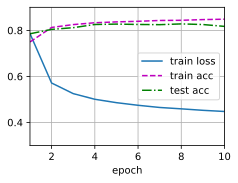

In [50]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

## 3.6.7 预测

- 训练完成后即可**对图像进行分类预测**。
- 给定一系列图像，模型将比较它们的实际标签（文本输出的第一行）和模型预测（文本输出的第二行）。


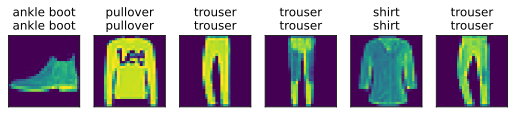

In [51]:
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

## 小结

* 借助softmax回归，我们可以训练多分类的模型。
* 训练softmax回归循环模型与训练线性回归模型非常相似：<b>先读取数据，再定义模型和损失函数，然后使用优化算法训练模型。大多数常见的深度学习模型都有类似的训练过程。

--------------
- **说明：torch.utils.data.DataLoader的用法**
  - 在本节开始的代码`train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)`返回就是一个`DataLoader`对象。
`torch.utils.data.DataLoader` 是一个用于加载数据的工具类，它可以将输入数据（通常是由自定义数据集类封装的数据）分批次（batch）并进行**打乱**、**采样**等操作。它使得在训练和评估神经网络时可以方便地使用小批量数据。

  - 初始化 `DataLoader`：创建一个 `DataLoader` 实例，需要传递一些参数：

    - `dataset`: 一个实现了 `__getitem__()` 和 `__len__()` 方法的数据集对象（通常是一个继承自` torch.utils.data.Dataset` 的类实例）。
    - `batch_size`: 每个批次包含的样本数量。默认值为`1`。
    - `shuffle`: 布尔值，表示是否在每个epoch开始时打乱数据。对于训练数据，通常设置为 `True` 以提高模型泛化能力；对于验证或测试数据，通常设置为 `False`。默认值为`False`。
    - `sampler`: 可选参数，用于指定如何从数据集中抽取样本。默认情况下，如果 `shuffle=True`，则使用 `RandomSampler`；否则使用 `SequentialSampler`。
    - `num_workers`: 用于数据加载的子进程数。默认值为`0`，表示在主进程中加载数据。增加 `num_workers` 可以利用多核CPU并行加载数据，提高数据加载速度。**此参数慎用，有可能出错**。
    - `pin_memory`: 布尔值，表示是否将数据存储在固定内存（CUDA pinned memory）中。对于GPU训练，设置为True可以加速数据从CPU到GPU的传输。默认值为 `False`。
    - 其他参数，如 `collate_fn`（定义如何将多个样本组合成一个批次）、`drop_last`（布尔值，表示是否丢弃最后一个不完整的批次），等。
  
  - `DataLoader` 是一个可迭代对象，因此你可以直接在 `for` 循环中使用它来遍历数据。每次迭代返回一个批次的数据（通常是一对输入和标签）。例如：`for inputs, labels in data_loader:`在这个迭代中进行小批量数据处理，更新参数等。

  - **示例**：

In [133]:
import torch
from torch.utils.data import Dataset, DataLoader

import os

os.environ['OMP_NUM_THREADS'] = '1'
# 自定义数据集类
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

    def __len__(self):
        return len(self.data)

# 示例数据
data = torch.randn(100, 3)
labels = torch.randint(0, 2, (100,))

# 创建数据集实例
my_dataset = MyDataset(data, labels)

# 创建 DataLoader 实例
data_loader = DataLoader(my_dataset, batch_size=10, shuffle=True)

# 使用 DataLoader 遍历数据
for inputs, labels in data_loader:
    print("Inputs:", inputs)
    print("Labels:", labels)


Inputs: tensor([[ 0.6209,  1.9145,  0.5645],
        [-2.6522, -0.4375,  0.3523],
        [-0.2786,  1.1414,  1.5453],
        [ 1.1538,  1.1126,  0.7759],
        [-0.8173, -0.4234, -0.1316],
        [-1.4438, -1.1009,  0.4670],
        [-1.5261,  0.9095,  0.2599],
        [ 0.2395,  0.3588, -0.5085],
        [-0.7853,  0.5052, -1.1464],
        [ 0.6240, -0.9912, -1.4868]])
Labels: tensor([0, 1, 0, 0, 1, 0, 1, 0, 1, 0])
Inputs: tensor([[ 0.4284,  0.3846, -2.2233],
        [-2.5599,  0.6723, -0.7586],
        [-0.3915, -0.7430,  0.0284],
        [ 0.1503,  0.9303, -1.0305],
        [-0.9903,  1.2597,  0.4988],
        [-0.0128,  0.7694,  0.0325],
        [-1.0266, -2.0273, -0.0694],
        [-1.6367,  0.2958,  0.1520],
        [-0.4374,  1.3355,  0.3531],
        [-0.4360,  0.6908, -0.0801]])
Labels: tensor([0, 1, 1, 1, 0, 0, 1, 0, 0, 1])
Inputs: tensor([[-1.1537, -0.0262, -0.5848],
        [-0.5474,  0.2360, -0.2686],
        [ 0.8353,  0.5126, -0.1830],
        [ 0.4092, -0.4380,  0

-----------